# Data

In this notebook we load the datasets and take some informal views of them (you can play a bit more at the end to get a better feeling of how the data are structured).

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Movie dataset
The data where recorded in an fMRI experiment where subjects were in one of two conditions (over 5 sessions): resting state and movie viewing.

At the end of the notebook there is a schematic description of the projects.

In [2]:
sns.set_context('talk')  # draws big plots
sns.set_palette('Set1')  # set the colormap for all plots

ts = np.load("../datasets/movie/ts_emp.npy")  # load data

N = ts.shape[0]  # number of subjects
C = np.array([0, 0, 1, 1, 1])  # conditions
T = ts.shape[3]  # number of time samples
P = ts.shape[2]  # number of ROIs in the parcellation

print("number of subjects: {0} \nthere are {1} resting sessions \nand {2} movie sessions\neach session has {3} time samples and {4} ROIs\nthe dataset ts has shape: {5}".format(N, np.sum(C==0), np.sum(C==1), T, P, ts.shape))

number of subjects: 22 
there are 2 resting sessions 
and 3 movie sessions
each session has 300 time samples and 66 ROIs
the dataset ts has shape: (22, 5, 66, 300)


### Time series

Let's have a look at some example time series from the dataset.

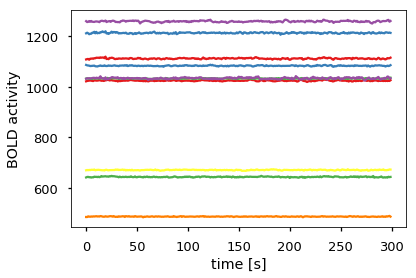

In [3]:
# plot first the time course of first 10 ROIs for first subject first session
X = ts[0, 0, :, :]  # select one subject
plt.plot(X[:10, :].T)
plt.xlabel('time [s]')
plt.ylabel('BOLD activity')
plt.show()

As you can see each ROI has a different mean so that the variability of the signal is not clearly visible when many ROIs are plotted together. Let's remove the mean of each time series to make the variability evident (correlations are also calculated on zero-centred time series).

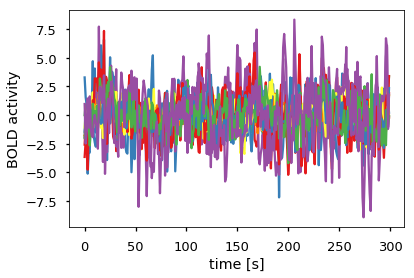

In [4]:
# subtract the mean and plot again
X_demeaned = X - np.outer(X.mean(axis=1), np.ones(T))
plt.plot(X_demeaned[:10, :].T)
plt.xlabel('time [s]')
plt.ylabel('BOLD activity')
plt.show()

### Distributions

Let's have a look at the distribution of BOLD signal for one subject in the two different conditions. Do they look different?

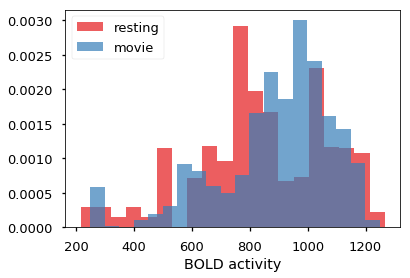

In [5]:
# distribution of BOLD activity for resting and movie of first subject
a = ts[0, :2, :, :].flatten()  # resting sessions
b = ts[0, 2:, :, :].flatten()  # movie sessions
plt.hist(a, bins=20, density=True, alpha=0.7, label='resting')
plt.hist(b, bins=20, density=True, alpha=0.7, label='movie')
plt.xlabel('BOLD activity')
plt.legend()
plt.show()

A fancier way of representing distributions is the so called violin plot, where the colored are represents the desity of data (inside each violin there is small box plot.

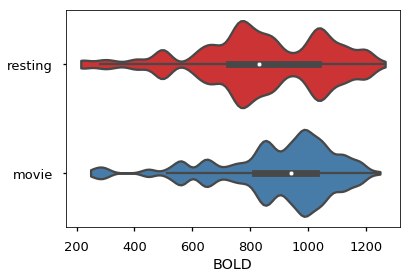

In [6]:
# show the distribution again as violin plots
fig, ax = plt.subplots(nrows=1, ncols=1)
sns.violinplot(data=[a, b], cut=0, orient='h', scale='width', ax=ax)
ax.set_yticklabels(['resting', 'movie'])
ax.set_xlabel('BOLD')
plt.show()

We can also check the distribution of the demeaned BOLD signal for one ROI. Does it look like Gaussian?

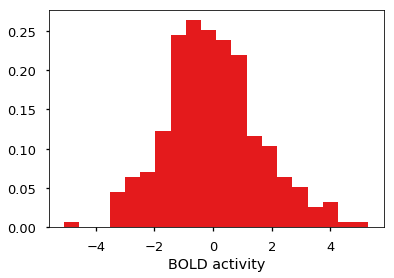

In [7]:
plt.hist(X_demeaned[0, :], bins=20, density=True)
plt.xlabel('BOLD activity')
plt.show()

Let's evaluate the power spectrum of the BOLD signals.

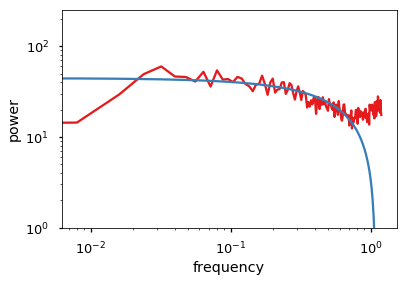

In [8]:
# calculate the power spectrum average over the ROIs for a single session

spec = np.fft.fft(X_demeaned, axis=1)[:,:int(T/2)]
av_pow_spec = np.abs(spec).mean(0)
freq = np.fft.fftfreq(T, d=1./2.4)[:int(T/2)]
 
plt.figure()
plt.plot(freq, av_pow_spec) # data spectrum
a1,a0 = np.polyfit(freq[5:100], av_pow_spec[5:100], 1) # linear fit
plt.plot(freq, a0+a1*freq)
plt.xscale('log')
plt.yscale('log')
plt.axis(ymin=1)
plt.xlabel('frequency')
plt.ylabel('power')
plt.show()

### <font color="blue"> Exercises

Explore a bit more the dataset using modified versions of previous cells. The points below are just some guidelines.

- Look at the last 10 time series of the first subject first session
- Look at 10 randomly chosen time series
- Look at other subjects' time series
- Look at the distribution of BOLD over time of other ROIs
- Look at the distribution of BOLD over time of all time series together
- Look at the distributions of the two conditions for all subjects together
- $\star$ Use the function plt.scatter() to show the association of the BOLD of two subjects on the first session.

## 2. Structural dataset + resting state

These are data from a resting state experiment where each subject has only one session.

### Structural data

The structural data are diffusion tensor imaging (DTI) scans for each subject.
DTI describes the strength of anatomical connections between ROIs.

In [9]:
sc = np.load("../datasets/resting/Human/SCnets_20subs.npy")
print("The structural connectivity data sc has shape: {0}".format(sc.shape))

The structural connectivity data sc has shape: (20, 68, 68)


Let's have a look at these structural connectivity matrix. This is the SC for the first subject:

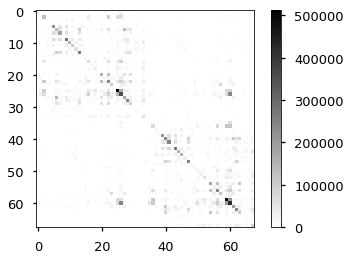

In [10]:
plt.figure()
plt.imshow(sc[0, :, :], cmap=plt.cm.binary)
plt.colorbar()
plt.show()

Let's plot the distribution of connectivity strength for one subject.

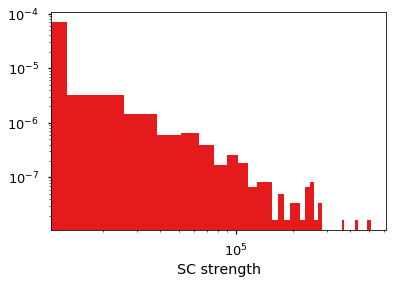

In [11]:
plt.figure()
plt.hist(sc[0, :, :].flatten(), bins=40, density=True)
plt.xlabel('SC strength')
plt.xscale('log')
plt.yscale('log')
plt.show()

### Functional data

In [12]:
tsr = np.load("../datasets/resting/Human/BOLD_20subs_Detrended.npy")
tsr.shape

N = ts.shape[0]  # number of subjects
T = ts.shape[2]  # number of time samples
P = ts.shape[1]  # number of ROIs in the parcellation

print("number of subjects: {0} \neach session has {1} time samples and {2} ROIs".format(N, T, P))

number of subjects: 22 
each session has 66 time samples and 5 ROIs


### <font color="blue"> Exercises

- Plot the time series for the resting state as with the movie dataset. Are BOLD activity distributions different across subjects (scipy.stats.ttest_ind)?
- Plot the distribution of BOLD signal for all ROIs of one subject. Does it look like Gaussian (scipy.stats.normaltest)? What about the distribution for individual ROIs?
- Plot the SC network and distribution for other subjects.
- Plot the distribution for all subjects together.

## 3. EEG time series

These are data from an EEG experiment for a single subject with attention to the left or right side of the visual field. The time series are in two matlab files, ARH for attention to the right and ALH for attention to the left.

Courtesy of Mireia Torralba and Salvador Soto-Faraco.

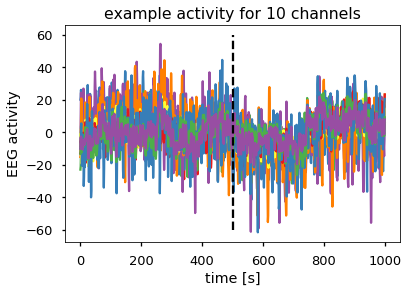

In [13]:
trials_tmp_L = sio.loadmat('../datasets/EEG/trials_ALH.mat')['trials']
trials_tmp_R = sio.loadmat('../datasets/EEG/trials_ARH.mat')['trials']

# EEG channel properties    
N = 58 # number of channels (electrodes)

T = 1001 # number of time points for each trial
t_stim = 500 # time point for stimulus onset
sampling_rate = 500. # sampling rate for EEG signal

# gather all data in a single array
n_trials = 140 + 115 # left + right
trials = np.zeros([n_trials,N,T]) # channel activity for all trials
trial_labels = np.zeros([n_trials]) # result of trial
for i_trial in range(140):
    # get channel activity
    trials[i_trial,:,:] = trials_tmp_L[0,i_trial]
for i_trial in range(115):
    # get channel activity
    trials[i_trial+140,:,:] = trials_tmp_R[0,i_trial]

plt.figure()
plt.plot(range(T), trials[0,:10, :].T)
plt.plot([t_stim, t_stim], [-60, 60], '--k')
plt.xlabel('time [s]')
plt.ylabel('EEG activity')
plt.title('example activity for 10 channels')
plt.show()

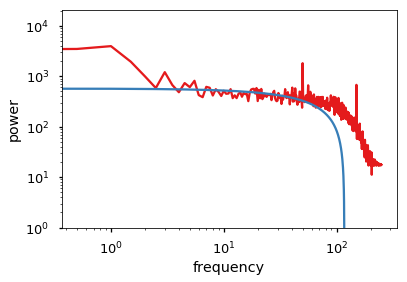

In [14]:
# calculate the power spectrum average over the channels for a single trial

spec = np.fft.fft(trials[0,:,:], axis=1)[:,:int(T/2)]
av_pow_spec = np.abs(spec).mean(0)
freq = np.fft.fftfreq(T, d=1./sampling_rate)[:int(T/2)]
 

plt.figure()
plt.plot(freq, av_pow_spec) # data spectrum
a1,a0 = np.polyfit(freq[5:100], av_pow_spec[5:100], 1) # linear fit
plt.plot(freq, a0+a1*freq)
plt.xscale('log')
plt.yscale('log')
plt.axis(ymin=1)
plt.xlabel('frequency')
plt.ylabel('power')
plt.show()

### <font color="blue"> Exercises

- $\star$ Plot the activity and frequency spectrum for other trials, for a single channel averaged over trials, etc.